In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import glob
import pandas as pd
from collections import OrderedDict

In [6]:
directories = glob.glob('.experiments/end-effector_validate_set/*/*/result*.pth')

#load each 
results = {}
seed = 0
is_one_model = False
for pth in directories:
    dt = pth.split('/')[-1].split('-dt-')[-1].split('-')[0]
    algorithm = pth.split('/')[2] + '-' + dt
    
    result = torch.load(pth)
    if algorithm in results and not is_one_model:
        start = len(results[algorithm])
        end = len(results[algorithm]) + len(result)
        j = 0
        for i in range(start, end):
            results[algorithm][i] = result[j]
            j += 1        
    elif algorithm in results and is_one_model:
        results[algorithm + "-" + str(seed)] = result
        seed += 1
    else:
        results[algorithm] = result
    

In [7]:
results.keys()

dict_keys(['blackbox-kinematics-results', 'global-locallinear-kd-results', 'broyden-results', 'knn-neuraljacobian-results', 'inversejacobian-results', 'local-uvs-results', 'multitask-knn-neuraljacobian-results', 'global-neuralnetwork-results', 'global-neuralnetwork-multitask-results'])

In [8]:
labels = [
            ("inversejacobian-results", "True Jacobian"),
            ("broyden-results", "Broyden"),
          ("local-uvs-results", "Finite Difference"),
            ("global-locallinear-kd-results", "KNN Local Linear"),
          ("blackbox-kinematics-results", "Neural Kinematics"),
          ("global-neuralnetwork-results", "Neural Jacobian"),
          ("global-neuralnetwork-multitask-results", "Multitask Neural Jacobian"),
        #("knn-neuraljacobian-results", "KNN Neural Jacobian"),
        #("multitask-knn-neuraljacobian-results", "Multitask KNN Neural Jacobian")
         ]
labels = OrderedDict(labels)
new_results = []
for label in labels:
    for k in results.keys():
        if label == k:
            print(k, label)
            new_results.append([labels[label], results[k]])
            
results = new_results

results = OrderedDict(new_results)



inversejacobian-results inversejacobian-results
broyden-results broyden-results
local-uvs-results local-uvs-results
global-locallinear-kd-results global-locallinear-kd-results
blackbox-kinematics-results blackbox-kinematics-results
global-neuralnetwork-results global-neuralnetwork-results
global-neuralnetwork-multitask-results global-neuralnetwork-multitask-results


In [9]:
results.keys()

odict_keys(['True Jacobian', 'Broyden', 'Finite Difference', 'KNN Local Linear', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

# Plot Error Curves
In this section we want to see if our Jacobian estimates with our neural network actually solve the undlerying task of interest (i.e. moving the end effector to some target position)

In [10]:
def collect_eps_errs(result, dim=-1):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            state = v[5] #should be....state
            if dim < 0:
                psn = state[0:3]
                targ = state[-3:]
                mse = np.linalg.norm(targ - psn, 2)
                rmse = np.sqrt(mse)
                
                #mse = rmse
            else:
                psn = state[dim]
                targ = state[-3 + dim]
                mse = np.sqrt((targ - psn) ** 2)
            episode_err.append(mse)
        err_over_time.append(episode_err)
    return np.array(err_over_time).T

def plot_mu_sig(data, label=None, axis=1, ax=None,line_stype='b-'):
    samples = np.array(data)
    mean = samples.mean(axis=axis)
    std = samples.std(axis=axis)
    ste = std / np.sqrt(samples.shape[0]) #this is a hack, if axis not == 1, this will break
    
    if ax is None:
        plt.plot(mean, line_stype, label=label)
        plt.fill_between(list(range(mean.shape[0])), mean + std, mean - std, alpha=0.1)
    else:
        ax.plot(mean,line_stype, label=label)
        #ax.errorbar(list(range(mean.shape[0])), mean, yerr=std /np.sqrt(samples.shape[0]) , label=label)
        ax.fill_between(list(range(mean.shape[0])), mean + ste, mean - ste, color=line_stype[0], alpha=0.1)

In [11]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [12]:
line_types = [
            ("True Jacobian", "b|-"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
         ("KNN Local Linear", "g--"),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--"),
          #("KNN Neural Jacobian", "b"),
          #("Multitask KNN Neural Jacobian", "c-.")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'Broyden', 'Finite Difference', 'KNN Local Linear', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

106
414
455
125


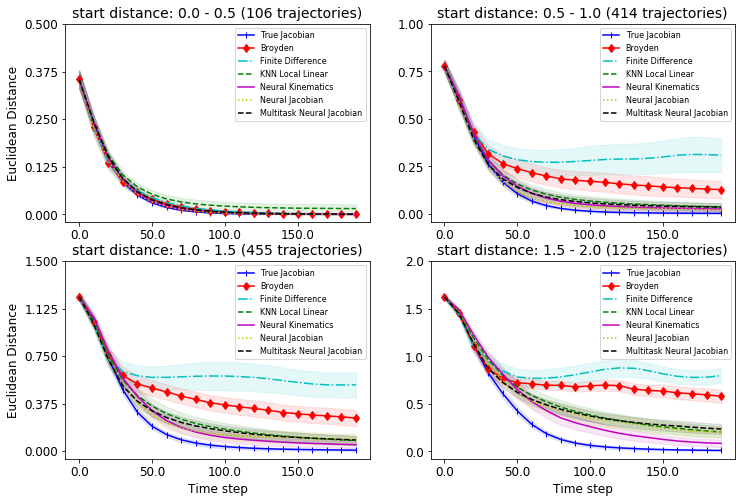

In [47]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE + 2)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    
bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
n_plts = len(bounds) - 1
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        num_trajs = np.sum(to_plot)
        line_type = line_types[algorithm]
        plot_mu_sig(err_over_time[0:200:10, to_plot], label=algorithm, ax=ax, line_stype=line_type)
    
    print(num_trajs)
    ax.get_yaxis().set_ticks(np.linspace(0.0, end, 5))
    ax.legend()
    ax.set_title("start distance: {} - {} ({} trajectories)".format(start, end, num_trajs))
    
    i += 1
    if i == 1 or i == 3:
        ax.set_ylabel("Euclidean Distance")
    
    if i == len(bounds) - 1 or i == 3:
        ax.set_xlabel("Time step")

    ax.set_xticklabels(labels = 20* np.arange(-2.5, 20, 2.5))
        
    
plt.savefig('pt_to_pt_error_curves.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 

# Violin Plots of End Performance

In this section we focus on the performance at the end of each episode. specifically whether or not the target was reached

In [14]:

violin_results = []
for algorithm, result in results.items():
    print(algorithm)
    err_over_time = collect_eps_errs(result, dim=-1)
    violin_results.append([algorithm, err_over_time])
    
violin_results = OrderedDict(violin_results)

True Jacobian
Broyden
Finite Difference
KNN Local Linear
Neural Kinematics
Neural Jacobian
Multitask Neural Jacobian


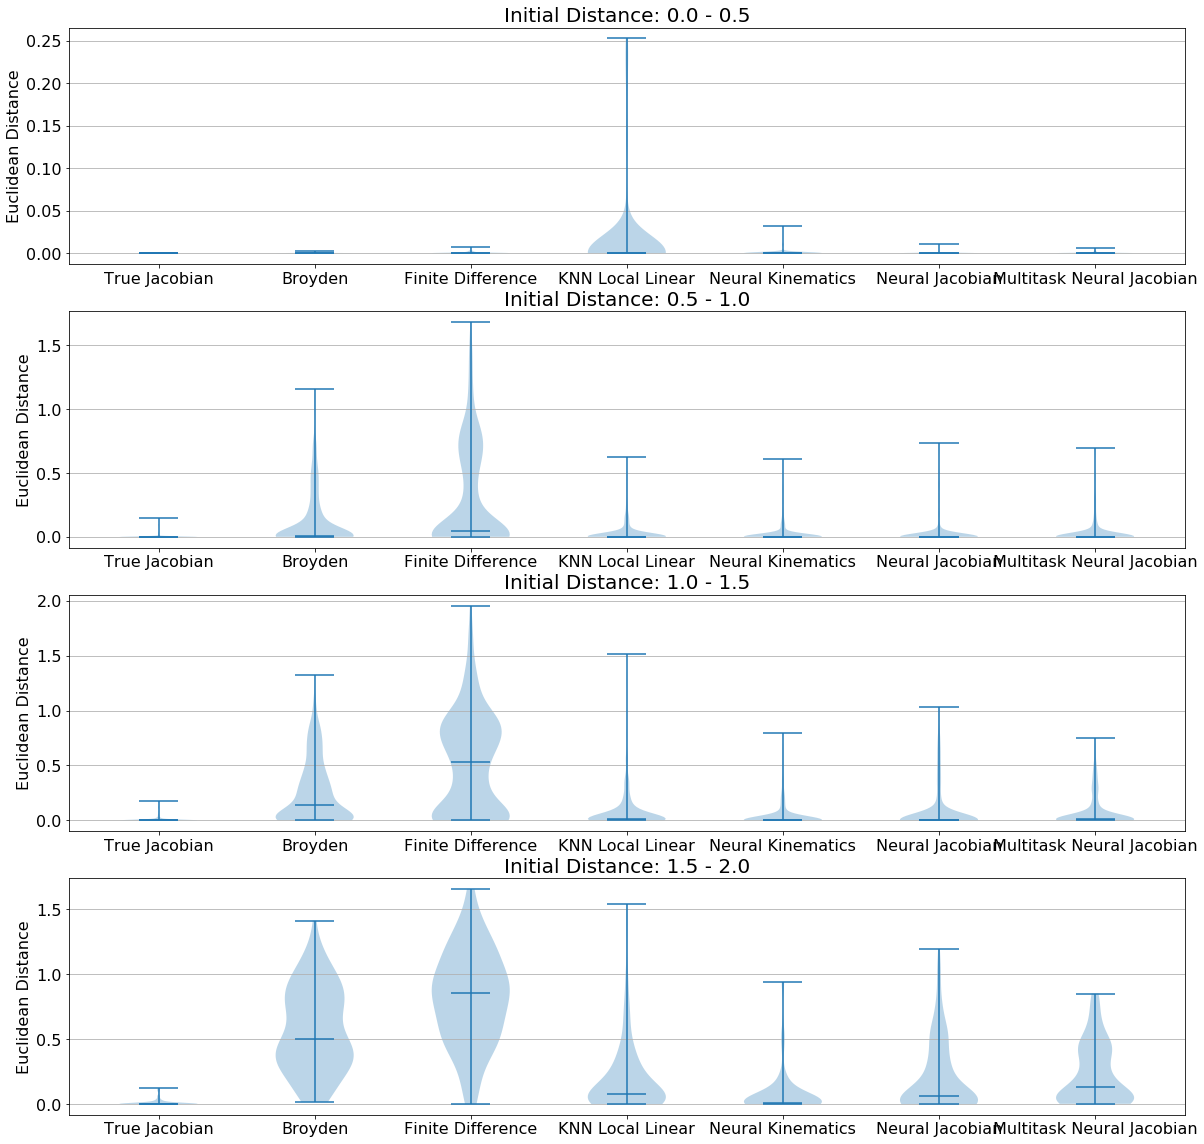

In [15]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(4, 1, figsize=(20, 20))


bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
successTable = {}
i = 0
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    end_dists = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        
        percentage = to_plot.sum() / count[-1]
        end_dist = err_over_time[-1, to_plot]  # for delta t between each timestep
        #end_dist = end_dist[to_plot]
        
        
        end_dists.append(end_dist)
        labels.append(algorithm)
    ax = axs[i]
    i+= 1
    ax.violinplot(end_dists, showmeans=False, showmedians=True, showextrema=True)
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels([l.format(len(a)) for l, a in zip(labels, end_dists)])
    ax.yaxis.grid(True)
    ax.set_ylabel("Euclidean Distance")
    ax.set_title("Initial Distance: {} - {}".format(low, high))

plt.savefig('pt_to_pt_violion_end_position.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# These are just tables of statistics from the trajectories 
The basic question is whether or not they reached the target. 
We considered the target reached by some threshold


In [16]:
err_curr_res = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time

In [17]:
thresh = 0.005
successTable = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        to_plot = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)
        CONST = 1

        percentage = to_plot.sum() / count[-1] * 100.0 #so it's between 0 - 100%
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in successTable:
            successTable[algorithm] = {"{}m - {}m".format(low,high): percentage}
        else:
            successTable[algorithm]["{}m - {}m".format(low,high)] = percentage
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    succeses = (err_over_time[-1,:] <= thresh)
    percentage = succeses.sum() / err_over_time.shape[1] * 100.0 #so it's between 0 - 100%
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in successTable:
            successTable[algorithm] = {"Overall": percentage}
    else:
        successTable[algorithm]["Overall"] = percentage
    
successTable = pd.DataFrame.from_dict(successTable).round(2).transpose()
successTable

,0.0m - 0.5m,0.5m - 1.0m,1.0m - 1.5m,1.5m - 2.0m,Overall
Broyden,100.00,51.93,18.90,0.0,37.00
Finite Difference,98.11,39.61,17.58,2.4,31.91
KNN Local Linear,86.79,66.43,37.58,12.8,50.36
Multitask Neural Jacobian,99.06,74.64,35.82,3.2,52.82
Neural Jacobian,99.06,84.54,65.71,25.6,71.45
Neural Kinematics,97.17,79.23,65.05,40.0,70.64
True Jacobian,100.00,94.93,83.30,76.0,88.45


In [18]:
#Get bounds from inverse kinematics
iJ_bounds = {}
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    err_over_time = violin_results["True Jacobian"].06	84.54	65.71	25.6	71.45
    to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)

    final_errs = err_over_time[-1,to_plot]
    mini = min(final_errs)
    maxi = max(final_errs)

    iJ_bounds["{}-{}".format(low,high)] = {"low": mini , "high":maxi}
    
print(iJ_bounds)



{'1.5-2.0': {'low': 7.116077582803582e-05, 'high': 0.12018592902427913}, '0.5-1.0': {'low': 1.7564264165461597e-05, 'high': 0.14440706565750236}, '0.0-0.5': {'low': 2.5991198986631186e-06, 'high': 2.9230458624725406e-05}, '1.0-1.5': {'low': 3.704716412077617e-05, 'high': 0.17668627803596884}, '0.0-2.0': {'low': 2.5991198986631186e-06, 'high': 0.17668627803596884}}


In [19]:
successesTable = {}
count = []
step_size = 0.001
highest = 0.1
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        count.append(to_plot.sum())
        
        ij_b = iJ_bounds["{}-{}".format(low,high)]
        
        #step_size = (ij_b["high"] - ij_b["low"] ) / 100
        #range_to_thresh = np.arange(ij_b["low"], ij_b["high"] + step_size, step_size )
        range_to_thresh = np.arange(0, highest, 0.001)
        for thresh in range_to_thresh:
            success = np.logical_and(to_plot, err_over_time[-1,:] <= thresh)

            percentage = success.sum() / count[-1] * 100.0 #so it's between 0 - 100%
            key = "{} - {}".format(low,high)
            if key == "{} - {}".format(bounds[0], bounds[-1]):
                key = "Overall"
            if not algorithm in successesTable:
                successesTable[algorithm] = {key: [percentage]}
            elif  key not in successesTable[algorithm] :
                successesTable[algorithm][key] = [percentage]
            else:
                successesTable[algorithm][key].append(percentage)
            


In [20]:
successes_auc_success_thresh = {}

num_thresh = len(np.arange(0, highest, 0.001))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:

    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    ij_b = iJ_bounds["{}-{}".format(low,high)]
    for algorithm in successesTable.keys():
        percentages = successesTable[algorithm][key]
        if not algorithm in successes_auc_success_thresh:
            successes_auc_success_thresh[algorithm] = {key: sum(percentages) / num_thresh }
        elif  key not in successes_auc_success_thresh[algorithm] :
            successes_auc_success_thresh[algorithm][key] = sum(percentages) / num_thresh

successes_auc_success_thresh_table = pd.DataFrame.from_dict(successes_auc_success_thresh).round(2).transpose()
successes_auc_success_thresh_table

,0.0 - 0.5,0.5 - 1.0,1.0 - 1.5,1.5 - 2.0,Overall
Broyden,98.92,60.91,35.13,3.34,47.37
Finite Difference,98.65,48.61,25.64,2.38,38.68
KNN Local Linear,91.05,80.41,64.24,37.70,69.89
Multitask Neural Jacobian,98.82,82.69,66.37,31.13,71.64
Neural Jacobian,98.89,90.28,74.89,45.25,79.63
Neural Kinematics,98.46,85.65,78.82,65.66,81.79
True Jacobian,99.00,96.91,93.33,90.02,94.85


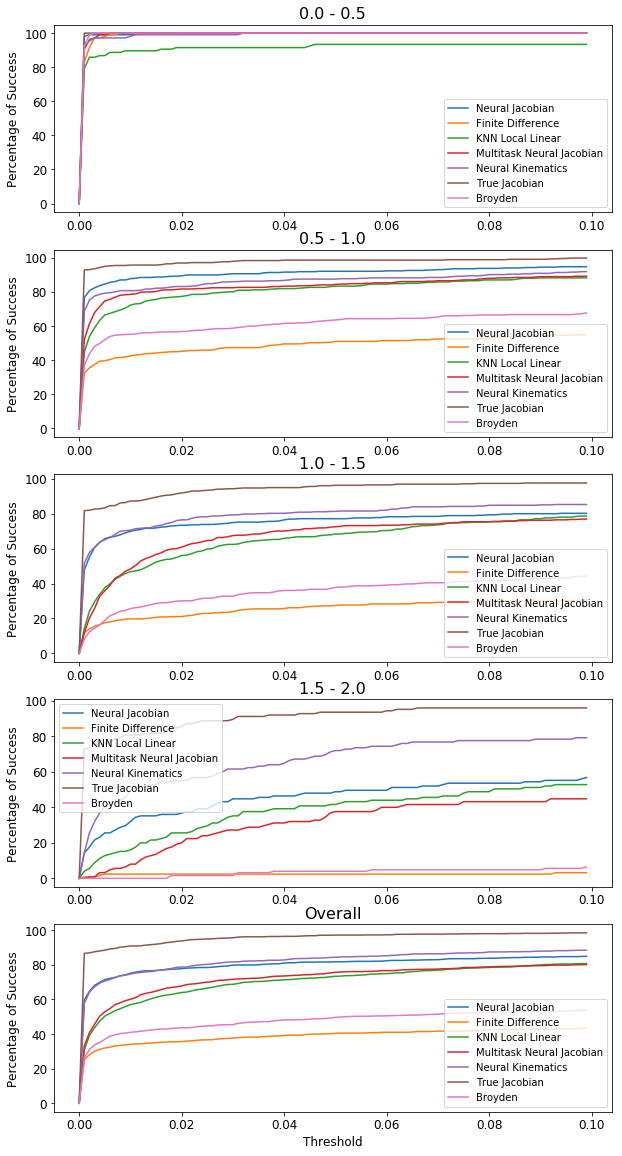

In [21]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

i = 0
num_thresh = len(np.arange(0, highest, 0.001))
for low, high in list(zip(bounds[:-1], bounds[1:])) + [(bounds[0], bounds[-1])]:
    ax = axs[i]
    i += 1
    key = "{} - {}".format(low, high)
    if key == "{} - {}".format(bounds[0], bounds[-1]):
        key = "Overall"
    ij_b = iJ_bounds["{}-{}".format(low,high)]
    #step_size = (ij_b["high"] - ij_b["low"] ) / 100
    #range_to_thresh = np.arange(ij_b["low"], ij_b["high"], step_size )
    range_to_thresh = np.arange(0, highest, 0.001)
    for algorithm in successesTable.keys():
        result = successesTable[algorithm][key]
        
        ax.plot(range_to_thresh, result, label=algorithm)
    ax.legend()
    ax.set_title(key)
    #ax.set_xticklabels(labels = ["{:.3f}".format(v) for v in range_to_thresh])
    ax.set_ylabel("Percentage of Success")
    if i == len(axs):
        ax.set_xlabel("Threshold")

['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']
[100.0, 51.93, 18.9, 0.0, 37.0]
[98.11, 39.61, 17.58, 2.4, 31.91]
[86.79, 66.43, 37.58, 12.8, 50.36]
[99.06, 74.64, 35.82, 3.2, 52.82]
[99.06, 84.54, 65.71, 25.6, 71.45]
[97.17, 79.23, 65.05, 40.0, 70.64]
[100.0, 94.93, 83.3, 76.0, 88.45]
['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']


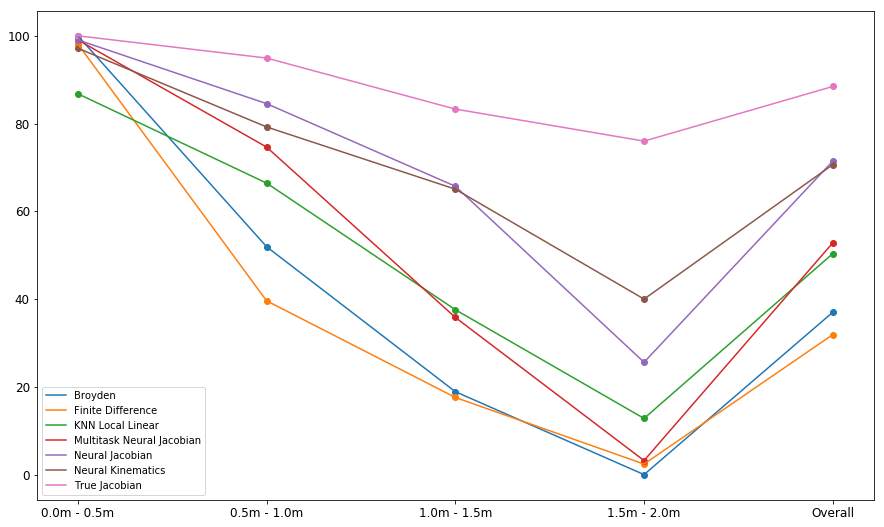

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = successTable.columns.values
rows = successTable.index.values
print(cols.tolist())
for r in rows:
    row = successTable.loc[r].tolist()
    print(row)
    ax.plot(row, label =r)
    ax.scatter(np.arange(len(row)), row)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

In [23]:
end_dist_table = {}
end_dist_table_std = {}
for low, high in zip(bounds[:-1], bounds[1:]):
    labels = []
    aucs = []
    count = []
    for algorithm, result in violin_results.items():
        err_over_time = result#collect_eps_errs(result, dim=-1)
        #Here, we WANT to sum over each run
        #above we do not because that is less meaninful
        
        to_plot = np.logical_and(err_over_time[0, :] >= low, err_over_time[0, :] < high)
        end_diff = err_over_time[-1,:]
        end_diff = end_diff[to_plot]
        
        
        mu = end_diff.mean()
        std = end_diff.std() / np.sqrt(np.sum(to_plot))
        algorithm = algorithm.split('-results')[0]
        if "global-" in algorithm:
            algorithm = algorithm.split('global-')[-1]
        
        if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"{}m - {}m".format(low,high): mu}
            end_dist_table_std[algorithm] = {"{}m - {}m".format(low,high): std}
        else:
            end_dist_table[algorithm]["{}m - {}m".format(low,high)] = mu
            end_dist_table_std[algorithm]["{}m - {}m".format(low,high)] = std
            
        if "global-neuralnetwork" in algorithm:
            labels.append(algorithm.split("global-")[-1])
        else:
            labels.append(algorithm)
    
for algorithm, result in violin_results.items():
    err_over_time = result
    end_diff = err_over_time[-1,:]
    mu = end_diff.mean()
    std = end_diff.std()  / np.sqrt(np.sum(to_plot)) #ste
    
    algorithm = algorithm.split('-results')[0]
    if "global-" in algorithm:
        algorithm = algorithm.split('global-')[-1]
    if not algorithm in end_dist_table:
            end_dist_table[algorithm] = {"Overall": mu}
            end_dist_table_std[algorithm] = {"Overall".format(low,high): std}
    else:
        end_dist_table[algorithm]["Overall"] = mu
        end_dist_table_std[algorithm]["Overall"] = std
        
    
end_dist_table = pd.DataFrame.from_dict(end_dist_table).round(3).transpose()
end_dist_table_std = pd.DataFrame.from_dict(end_dist_table_std).round(3).transpose()
end_dist_table

,0.0m - 0.5m,0.5m - 1.0m,1.0m - 1.5m,1.5m - 2.0m,Overall
Broyden,0.000,0.124,0.255,0.570,0.217
Finite Difference,0.001,0.308,0.523,0.815,0.425
KNN Local Linear,0.015,0.035,0.080,0.194,0.070
Multitask Neural Jacobian,0.000,0.034,0.085,0.231,0.074
Neural Jacobian,0.000,0.022,0.091,0.204,0.069
Neural Kinematics,0.001,0.024,0.048,0.080,0.038
True Jacobian,0.000,0.002,0.007,0.010,0.005


['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']
['0.0m - 0.5m', '0.5m - 1.0m', '1.0m - 1.5m', '1.5m - 2.0m', 'Overall']


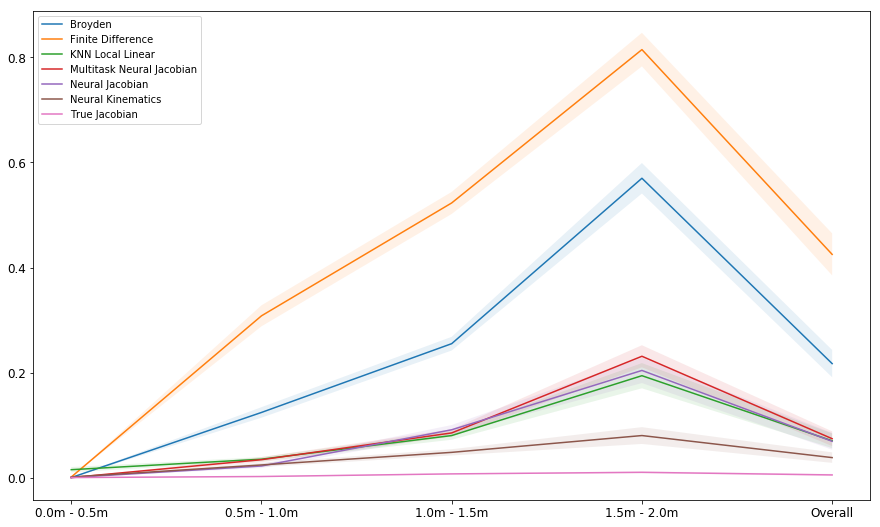

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cols = end_dist_table.columns.values
rows = end_dist_table.index.values
print(cols.tolist())
for r in rows:
    row = np.array(end_dist_table.loc[r].tolist())
    std = np.array(end_dist_table_std.loc[r].tolist())
    ax.plot(row, label = r)
    ax.fill_between(list(range(len(row))), row + std, row - std, alpha=0.1)
ax.legend()
ax.set_xticks(np.arange(len(row)))
ax.set_xticklabels(cols.tolist())
print(cols.tolist())

Text(0.5, 1.0, 'AUC of Trajectories for Different UVS Algorithms')

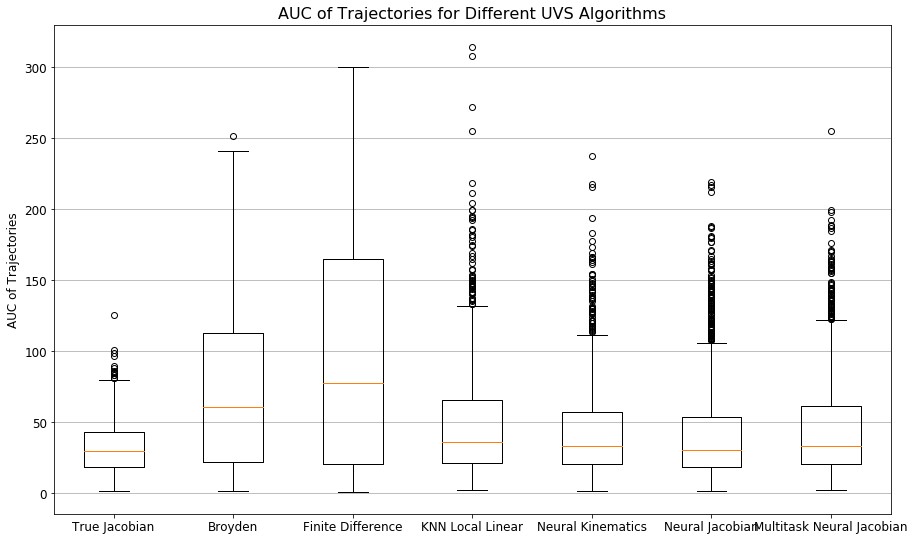

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

labels = []
aucs = []
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1) 
    #want to sum over each trajectory
    auc = err_over_time.sum(axis=0)  #for delta t between each time step
    aucs.append(auc)
    labels.append(algorithm)
    
ax.boxplot(aucs, labels=labels)

ax.yaxis.grid(True)
ax.set_ylabel("AUC of Trajectories")
ax.set_title("AUC of Trajectories for Different UVS Algorithms")

# Comparing Jacobians

Here, we just calaculate the difference between Jacobians in trajectories to see how much they differ from the true underlying Jacobian

In [26]:
def collect_jacobian_dist(result, norm=None):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            estimate_J = v[-2] 

            true_J = v[-1]
            if norm is not "signs":
                mse = np.linalg.norm(estimate_J - true_J, norm) #, 'fro')
            else:
                sign_mismatch = np.logical_not(np.logical_and(estimate_J, true_J))
                mse = (sign_mismatch).sum() #techinically not mind you...
            episode_err.append(mse)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [27]:
line_types = [
            ("True Jacobian", "b|-"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
         ("KNN Local Linear", "g--"),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--"),
          #("KNN Neural Jacobian", "b"),
          #("Multitask KNN Neural Jacobian", "c-.")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'Broyden', 'Finite Difference', 'KNN Local Linear', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

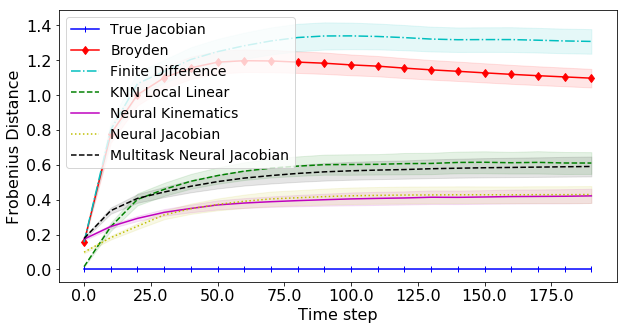

In [28]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for algorithm, result in results.items():
    jac_err = collect_jacobian_dist(result)
    line_type = line_types[algorithm]
    plot_mu_sig(jac_err[0:200:10, :], label=algorithm, ax=ax, line_stype=line_type)

ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))    
ax.set_xlabel('Time step')
ax.set_ylabel('Frobenius Distance')
#ax.set_title("Frobenius Norm Distance")
ax.legend()
plt.savefig('pt_to_pt_jacobian_diff_global.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

In [29]:
#collects results for plotting histograms and trajectories
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

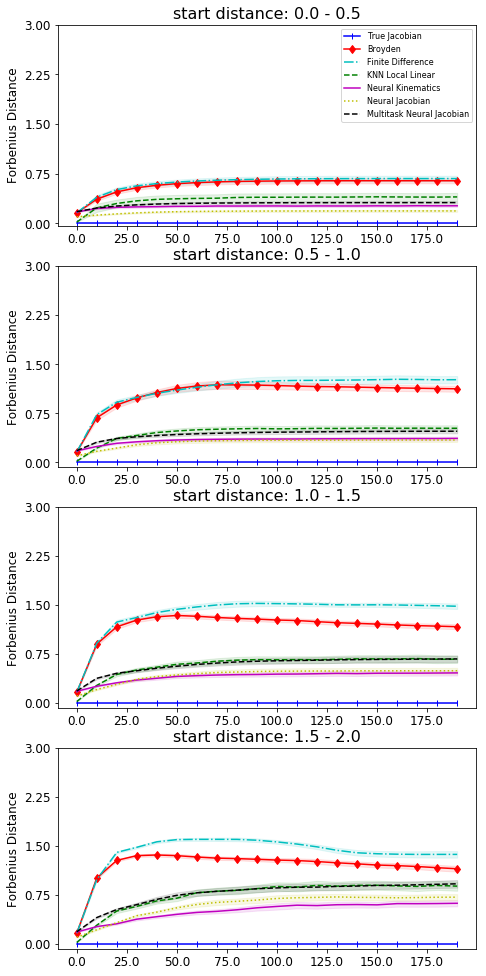

In [30]:
CONST = 1
SMALL_SIZE = 10 * CONST
MEDIUM_SIZE = 12 * CONST
BIGGER_SIZE = 16 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE - 2)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bounds = [0.0, 0.5, 1.0, 1.5, 2.0]
fig, axs = plt.subplots(4, 1, figsize=(7.5, 17))
axs = np.ndarray.flatten(axs)
i = 0
for start, end in zip(bounds[:-1], bounds[1:]):
    ax = axs[i]
    for algorithm in results.keys():
        err_over_time = err_curr_res[algorithm]
        to_plot = np.logical_and(err_over_time[0, :] >= start, err_over_time[0, :] < end)
        line_type = line_types[algorithm]
    
        plot_mu_sig(jac_errs[algorithm][0:200:10,to_plot], label=algorithm, ax=ax, line_stype=line_type)
        
    
    
    ax.get_yaxis().set_ticks(np.linspace(0.0, 3.0, 5))
    if i == 0:
        ax.legend()
    ax.set_title("start distance: {} - {}".format(start, end))
    
    #    ax.get_xaxis().set_ticks([])
    if i == 4:
        ax.set_xlabel("Time step")
    
    ax.set_ylabel("Forbenius Distance")
    ax.set_xticklabels(labels = 10* np.arange(-2.5, 20, 2.5))
    i += 1
    
plt.savefig('pt_to_pt_jacobian_diff_by_dist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)   

# Histograms of Jacobian difference
The previous plots were for trends over trajectories. The Jacobian differences are really independent of timesteps so to get a sense of these differences we visualize the results with histograms 


In [31]:
err_curr_res = {}
jac_errs = {}
for algorithm, result in results.items():
    err_over_time = collect_eps_errs(result, dim=-1)
    err_curr_res[algorithm] = err_over_time
    jac_err = collect_jacobian_dist(result)
    jac_errs[algorithm] = jac_err

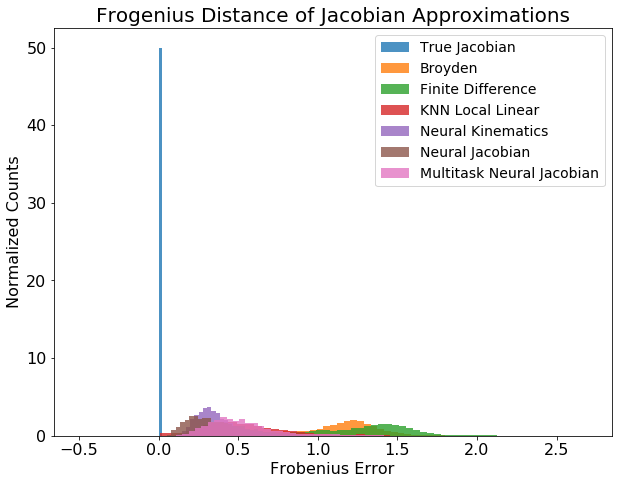

In [32]:
CONST = 1
SMALL_SIZE = 14 * CONST
MEDIUM_SIZE = 16 * CONST
BIGGER_SIZE = 20 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5))

for algorithm, result in results.items():
    if "Inverse" in algorithm:
        continue
    #jac_err = collect_jacobian_dist(result)
    jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=50, alpha=0.8, density=True, label=algorithm)
    
ax.set_xlabel('Frobenius Error')
ax.set_ylabel('Normalized Counts')
ax.set_title("Frogenius Distance of Jacobian Approximations")
ax.legend()

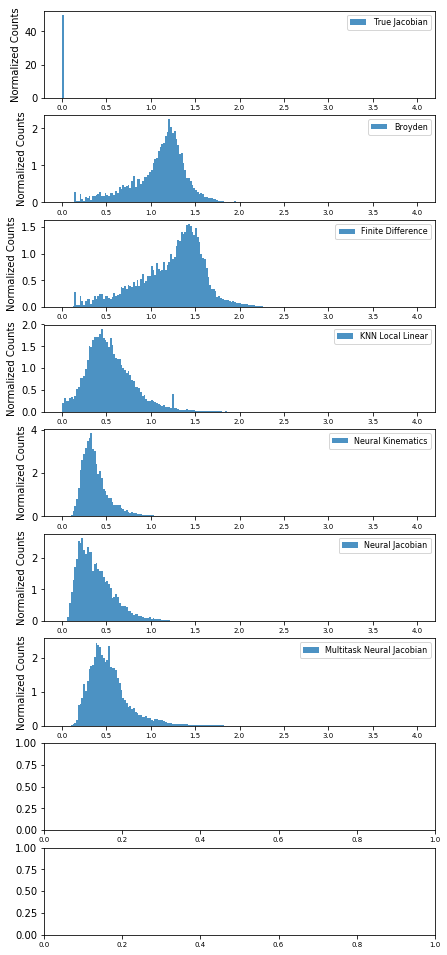

In [33]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE -1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Focusing only on the frobenius norm
fig, axs = plt.subplots(9, 1, figsize=(7, 17))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Inverse" in algorithm:
        continue
    ax = axs[i]
    i += 1
    jac_err = jac_err = jac_errs[algorithm]
    jac_err = jac_err.flatten()

    ax.hist(jac_err, bins=200, alpha=0.8, density=True, range=(0, 4), label=algorithm)
    #if i == 1:
    #    ax.set_title("F")
    ax.legend()
    #if i == 1 or i == 4:
    ax.set_ylabel('Normalized Counts')
    if i == 6:
        ax.set_xlabel("Frobenius Error")


plt.savefig('pt_to_pt_jacobian_hist.pdf',bbox_inches = 'tight',
    pad_inches = 0.1)  

# On the rank of our Jacobian
In these plots we're mostly interested in seeing whether or not our Jacobian's are full rank or not. 
We also consider the ratio of the maximum to minimum singular values of the jacobian to see if we are in singularity configurations

In [34]:
def check_jacobian_dexterity(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = max(s) / min(s)
            #loss = np.all((s > 0)) #if all greater than 0 implies fu
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

def check_jacobian_rank(result):
    #we use 3rd dexterity definition in : 
    #https://vtechworks.lib.vt.edu/bitstream/handle/10919/30363/Chap4.pdf?sequence=7&isAllowed=y
    #this is just ratio of largest to smallest singular values 
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            n, m = J_hat.shape
            smaller_dims = min(n, m)
            _, s, _ = np.linalg.svd(J_hat, full_matrices=False, compute_uv=True, hermitian=False)
            s = s[:smaller_dims] #to determine if full rank on smaller dimension...i.e. the rows for me
            loss = np.all((s > 0.1)) #if all greater than 0.1 not super close to a singularity
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T

In [35]:
singular_values = {} 
for algorithm, result in results.items():
    if "inverse" in algorithm:
        continue
    singular_val_ratio = check_jacobian_dexterity(result)
    singular_values[algorithm] = singular_val_ratio
    

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
singular_values.keys()

dict_keys(['Neural Jacobian', 'Finite Difference', 'KNN Local Linear', 'Multitask Neural Jacobian', 'Neural Kinematics', 'True Jacobian', 'Broyden'])

/home/przystupa/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/przystupa/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


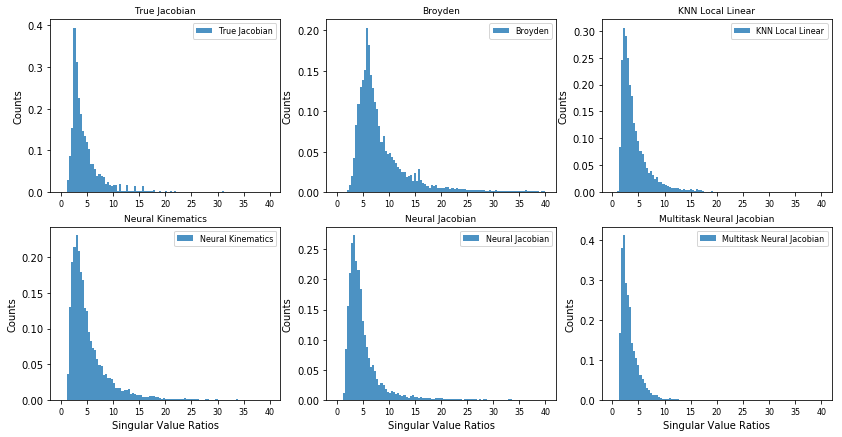

In [37]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# look at the distribution of the singular value ratios for dexterity in workspace
fig, axs = plt.subplots(2, 3, figsize=(14, 7))
axs = np.ndarray.flatten(axs)
i = 0
for algorithm, result in results.items():
    if "Finite" in algorithm:
        continue
    ax = axs[i]
    i += 1
    singular_val_ratio = singular_values[algorithm]
    singular_val_ratio = singular_val_ratio.flatten()

    ax.hist(singular_val_ratio, bins=100, alpha=0.8, density=True, range=(0, 40), label=algorithm)
    
    ax.set_ylabel('Counts')
    ax.set_title(algorithm)
    ax.legend()
    if i == (len(results) - 1) or i == 4 or i == 6 or i == 5:
        ax.set_xlabel('Singular Value Ratios')

# Checking for Criteria of Convergence
The last thing I want to check for is for whether or not the critieria on J is met for the trajectories. I will need to review this to make sure I understand it, but if JJ^{+} has any non-positive eigen values (0 or less) then hypothetically, it should not converge.

I think hypothetically JJ^{+} should be the identity matrix...and if it's not then we have problems otherwise, I'll need to read up on that. 

In [38]:
def check_pos_definite(A):
    eigs = np.linalg.eigvals(A)
            
    return (eigs > 0).all()
    
def check_jacobian_positive_definite(result, invert_true_J=False):
    err_over_time = []
    for k, value in result.items():
        episode_err = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            J_hat = v[-2] 
            J = v[-1]
            
            if invert_true_J:
                iJ_hat = np.linalg.pinv(J_hat)
                JiJ = np.matmul(J, iJ_hat)
            else:
                iJ = np.linalg.pinv(J)
                JiJ = np.matmul(J_hat, iJ)
            is_pos_def = check_pos_definite(JiJ)
            loss = int(is_pos_def)
            episode_err.append(loss)
        err_over_time.append(episode_err)    
    
    return np.array(err_over_time).T





In [39]:
jacobian_split = {}
for k, v in results.items():
    algorithm, result = k, v
    if "True" in algorithm:
        continue
        
    jac_err = check_jacobian_positive_definite(result)
    
    #check if criteria is met for whole trajectory or not
    always_pos_def = (jac_err.sum(axis=0) >=200)
    not_always_pos_def = (jac_err.sum(axis=0) < 200)
    
    total_traj = jac_err.shape[1]
    total_pos_d = always_pos_def.sum()
    total_not_pos_d = not_always_pos_def.sum()
    
    err_over_time = collect_eps_errs(result, dim=-1)
    traj_pos_def = err_over_time[:,always_pos_def]
    traj_not_pos_def = err_over_time[:, not_always_pos_def]
    
    jacobian_split[algorithm] = {"pos_def": traj_pos_def,
                                "not_pos_def": traj_not_pos_def,
                                 "pos_count": total_pos_d,
                                 "not_pos_count": total_not_pos_d,
                                 "total": total_traj
                                }
    

In [40]:
line_types = [
            ("True Jacobian", "b|-"),
            ("Broyden", "r-d"),
          ("Finite Difference", "c-."),
         ("KNN Local Linear", "g--"),
          ("Neural Kinematics", "m-"),
          ("Neural Jacobian", "y:"),
          ("Multitask Neural Jacobian", "k--"),
          #("KNN Neural Jacobian", "b"),
          #("Multitask KNN Neural Jacobian", "c-.")
         ]
line_types = OrderedDict(line_types)

line_types.keys()

odict_keys(['True Jacobian', 'Broyden', 'Finite Difference', 'KNN Local Linear', 'Neural Kinematics', 'Neural Jacobian', 'Multitask Neural Jacobian'])

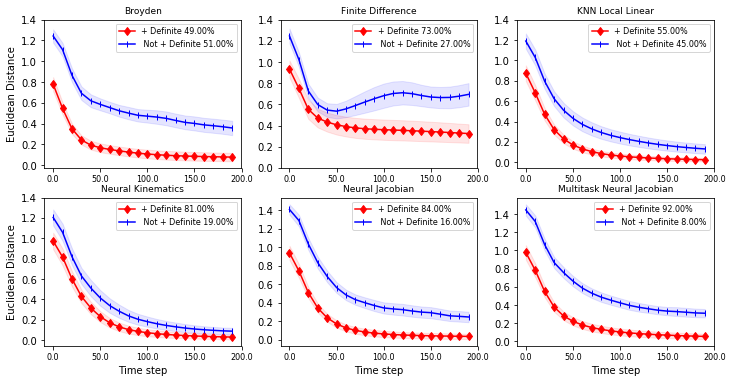

In [41]:
CONST = 1
SMALL_SIZE = 8 * CONST
MEDIUM_SIZE = 10 * CONST
BIGGER_SIZE = 14 * CONST

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE - 1)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE )    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#Focusing only on the frobenius norm
fig, axs = plt.subplots(2 , 3, figsize=(12, 6))
axs = np.ndarray.flatten(axs)
#if not isinstance(axs, list):
#    axs = [axs]
i = 0
for k, v in results.items():
    algorithm, result = k, v
    if "True" in algorithm:
        continue
    ax = axs[i]
    i += 1

    traj_pos_def = jacobian_split[algorithm]["pos_def"]
    traj_not_pos_def = jacobian_split[algorithm]["not_pos_def"]
    total_pos_d = jacobian_split[algorithm]["pos_count"]
    total_not_pos_d = jacobian_split[algorithm]["not_pos_count"]
    total_traj =  jacobian_split[algorithm]["total"]
    #plot_mu_sig(err_over_time, label="All {} Trajectories".format(total_traj), ax=ax)
    plot_mu_sig(traj_pos_def[0:200:10], label="+ Definite {:.2f}%".format(round(total_pos_d / total_traj, 2) *100.0), ax=ax, line_stype="r-d")
    plot_mu_sig(traj_not_pos_def[0:200:10], label=" Not + Definite {:.2f}%".format(round(total_not_pos_d / total_traj, 2) *100.0), ax=ax, line_stype="b|-")
    #if i >= len(axs) - 1:
    ax.set_xticklabels(labels = 20* np.arange(-2.5, 20, 2.5))
    if i >= 4:
        ax.set_xlabel('Time step')
    #else:
    #    ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(0, 1.6, 0.2))
    if i == 1 or i == 4:
        ax.set_ylabel('Euclidean Distance')
    ax.set_title("{}".format(algorithm))
    ax.legend()
    
plt.savefig('pt_to_pt_separate_by_pos_def.pdf',bbox_inches = 'tight',
    pad_inches = 0.1) 

# Check Environment  Conditioning
We just plot the condition numbers of Jacobians in these plots

In [51]:
def check_jacobian_condition(result):
    conditioning_over_time = []
    true_solution_over_time = []
    for k, value in result.items():
        eps_conditioning = []
        true_conditioning = []
        for v in value:
            #Check against true jacobian
            #If our approximation is good, presumably the matrix should still be positive definite
            # i.e. the approximate J is transferable 
            #this was backwards.....
            J_hat = v[-2] 
            J = v[-1]
            
            #print("condition numbers:")
            #print("J hat", np.linalg.cond(J_hat), "J", np.linalg.cond(J), "JiJ", np.linalg.cond(JiJ))
            hat_cond = np.linalg.cond(J_hat)
            true_cond = np.linalg.cond(J)
            
            #iJ_hat = np.linalg.pinv(J_hat)
            #JiJ = np.matmul(J, iJ_hat)
            
            #JiJ_cond = np.linalg.cond(JiJ)
            eps_conditioning.append(hat_cond)
            true_conditioning.append(true_cond)
            
        conditioning_over_time.append(eps_conditioning)    
        true_solution_over_time.append(true_conditioning)
    return np.array(conditioning_over_time).T, np.array(true_solution_over_time).T

In [52]:
jac_conds = {}
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]
    cond_hat, cond_true = check_jacobian_condition(result)
    jac_conds[algorithm] = cond_hat

In [56]:
# Checking conditioning of Matrix over episodes & comparing to true jacobian at those points

cond_stats = {}
for i, k_v in enumerate(results.items()):
    algorithm, result = k_v[0], k_v[1]
    #cond_hat, cond_true = check_jacobian_condition(result)
    jac_err = jac_conds[algorithm]
    jac_err = jac_err.flatten()
    is_not_inf = jac_err != np.inf
    jac_err = jac_err[is_not_inf]
    print(jac_err.mean(), jac_err.std() )
    if algorithm == "KNN Local Linear":  
        print(jac_err == np.inf)
    cond_stats[algorithm] = {'mean': jac_err.mean(), "standard deviation": jac_err.std()}

    #ax.hist(jac_err, bins=200, alpha=0.8, density=True,
    #        label= algorithm)
    #ax.legend()
    #ax.set_title(algorithm)
    #if i == 1 or i == 4:
    #ax.set_ylabel('Normalized Counts')
    #if i == 6:
    #    ax.set_xlabel("Jacobian Condition Number")
cond_table = pd.DataFrame.from_dict(cond_stats).round(3).transpose()
cond_table

5.024923 4.4560785
11.658026645821568 25.37340550427777
15.93267237356656 0.0
141.67727122391923 40410.91581999161
[False False False ... False False False]
5.4279222 4.462861
5.100916 4.0673475
3.289961 1.7954786


,mean,standard deviation
Broyden,11.658,25.373
Finite Difference,15.933,0.000
KNN Local Linear,141.677,40410.916
Multitask Neural Jacobian,3.290,1.795
Neural Jacobian,5.101,4.067
Neural Kinematics,5.428,4.463
True Jacobian,5.025,4.456
